# Attribution

For this assignment, I borrowed code from a GAN implementation by the user diegoalejogm <br>that I found on GitHub: <br>https://github.com/diegoalejogm/gans/blob/master/1.%20Vanilla%20GAN%20PyTorch.ipynb

The original code uses the MNIST dataset. I chose a different dataset, namely a collection of <br>small png images of countries' flags that I downloaded from http://flagpedia.net/download. <br>I deleted the comments from the original code, so all the comments here are my own.

# Imports

In [1]:
import numpy as np
import time
import random
from os import listdir
from os.path import isfile, join
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms

# Data

In [2]:
INPUT_DIR = "flags/"

In [3]:
# Importing images and converting to black and white:
file_names = [f for f in listdir(INPUT_DIR) if isfile(join(INPUT_DIR, f))]
images = [Image.open(INPUT_DIR + f).convert('LA') for f in file_names]

## Raw

Note that the raw data has differing dimensions on the x-axis.

In [32]:
images[:3]

[<PIL.Image.Image image mode=LA size=32x20 at 0x115A08668>,
 <PIL.Image.Image image mode=LA size=40x20 at 0x115A085F8>,
 <PIL.Image.Image image mode=LA size=30x20 at 0x115A77E10>]

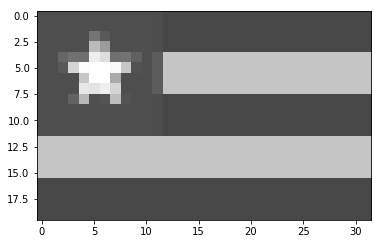

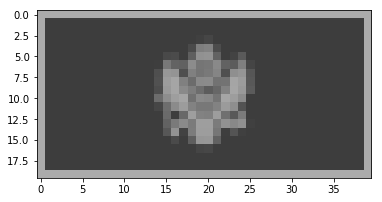

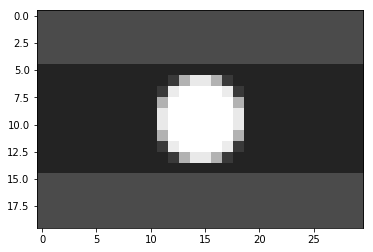

In [4]:
# The first three images from the dataset
for image in images[:3]:
    plt.figure()
    plt.imshow(image)

## Processing

In [5]:
def get_halves(n):
    """
    Returns a tuple of halves used to pad images.
    """
    if n%2 == 0:
        return int(n/2), int(n/2)
    return int(n/2), int(n/2)+1

def encode_img(img, output_dim=np.array([20, 51, 2])):
    """
    Takes a PIL black and white image and returns 
    a padded and normalized tensor with dim (20, 51).
    """
    a = np.array(img)
    overflow = tuple(output_dim - np.array(a.shape))
    pad_width = (
        get_halves(overflow[0]), 
        get_halves(overflow[1]), 
        get_halves(overflow[2])
    )
    return torch.from_numpy(
        np.pad(
            a, 
            pad_width=pad_width, 
            mode="constant", 
            constant_values=0
        )/float(255)
    )[:,:,0]

def decode_img(img):
    """
    Takes a tensor of dim (20, 51) and returns PIL image.
    """
    return Image.fromarray(
        (np.concatenate(
            (img.numpy().reshape(20, 51, 1), 
             np.full((20, 51, 1), 1)
            ),axis=2)*255).astype('uint8')
    )


In [6]:
processed_images = [encode_img(x) for x in images]

Images are padded and centered. The examples from above now look like this:

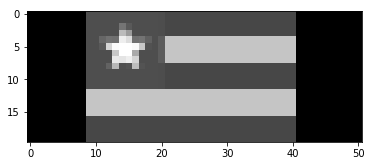

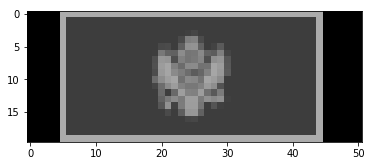

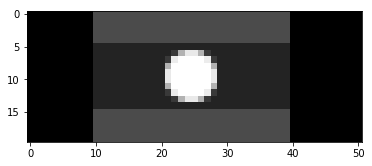

In [7]:
for image in processed_images[:3]:
    plt.figure()
    plt.imshow(decode_img(image))

# Models

## Discriminator

In [8]:
class DiscriminatorNet(torch.nn.Module):
    """
    This code is largely adapted from the GitHub code.
    My input dimensions are different (1020 features),
    otherwise I keep the same model structure.
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 1020
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            nn.Linear(256, n_out),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [9]:
d = DiscriminatorNet()

## Generator

In [10]:
class GeneratorNet(torch.nn.Module):
    """
    This code is largely adapted from the GitHub code.
    My output dimensions are different (1020 features),
    otherwise I keep the same model structure.
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 1020
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [11]:
g = GeneratorNet()

## Functions

In [12]:
def real_data_target():
    return torch.ones(1)

def fake_data_target():
    return torch.zeros(1)

def train_discriminator(optimizer, real_data, fake_data):
    # Training the discriminator
    # Resetting the gradients
    optimizer.zero_grad()
    
    # Predict, calculate loss, and backpropogate for real data
    prediction_real = d(real_data)
    error_real = loss(prediction_real, real_data_target())
    error_real.backward()

    # Predict, calculate loss, and backpropogate for fake data
    prediction_fake = d(fake_data)
    error_fake = loss(prediction_fake, fake_data_target())
    error_fake.backward()
    
    # Updating the weights
    optimizer.step()
    
    # Returning error for printing
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    # Training the generator
    # Resetting the gradients
    optimizer.zero_grad()
    
    # Predict, calculate loss, and backpropogate for fake data
    prediction = d(fake_data)
    error = loss(prediction, real_data_target())
    error.backward()
    
    # Updating the weights
    optimizer.step()
    
    # Returning error for printing
    return error

# Optimizers and loss function
# Initially the generator could not keep up with the discriminator 
# so I played around with the learning rate and found that a lower
# learning rate of 0.000075 worked better.
d_optimizer = optim.Adam(d.parameters(), lr=0.000075)
g_optimizer = optim.Adam(g.parameters(), lr=0.000075)
loss = nn.BCELoss()

## Training

In [13]:
# Initialize statistics
start_time = time.time()
epoch_images = []
g_errors = []
d_errors = []

# Looping over epochs
for epoch in range(101):
    
    # Storing generated sample images at frequent epochs 
    if epoch % 10 == 0:    
        epoch_images.append((epoch, [
            decode_img(
                g(torch.empty(100).normal_(0,1)).view(20,51).detach()
            ),
            decode_img(
                g(torch.empty(100).normal_(0,1)).view(20,51).detach()
            ),
            decode_img(
                g(torch.empty(100).normal_(0,1)).view(20,51).detach()
            ),
        ]))
        
    # Initialize error to be added over total trainig data
    g_error_total = 0
    d_error_total = 0
    
    # Looping over training data
    for real_image in processed_images:
        
        # Preparing real image from training data
        real_data = real_image.flatten().float()
        
        # Generating fake data with generator for discriminator
        fake_data = g(
            torch.empty(100).normal_(0,1)
        ).view(20,51).detach().flatten()
        
        # Training discriminator
        d_error, _, _ = train_discriminator(
            d_optimizer, 
            real_data, 
            fake_data
        )

        # Generating fake data with generator for generator
        fake_data = g(
            torch.empty(100).normal_(0,1)
        ).view(20,51).flatten()
        
        # Training generator
        g_error = train_generator(g_optimizer, fake_data)
        
        # Adding up error
        g_error_total += g_error
        d_error_total += d_error
    
    # Storing errors at epoch
    g_errors.append(g_error_total/float(len(processed_images)))
    d_errors.append(d_error_total/float(len(processed_images)))
    
    # Printing statistics
    if epoch % 10 == 0:
        print(
            "epoch: {}".format(epoch), 
            "\ngenerator error: {}".format(
                g_error_total/float(len(processed_images))
            ), 
            "\ndiscriminator error: {}".format(
                d_error_total/float(len(processed_images))
            ),
            "\ntraining time elapsed (min): {}\n\n".format(
                (time.time()-start_time)/float(60)
            )
        )

epoch: 0 
generator error: 1.3632155656814575 
discriminator error: 1.0054160356521606 
training time elapsed (min): 0.2211115002632141


epoch: 10 
generator error: 1.9713836908340454 
discriminator error: 0.9155210256576538 
training time elapsed (min): 2.0893439491589865


epoch: 20 
generator error: 1.0519938468933105 
discriminator error: 1.0327510833740234 
training time elapsed (min): 3.6794676303863527


epoch: 30 
generator error: 1.365185022354126 
discriminator error: 0.9190380573272705 
training time elapsed (min): 5.2092461307843525


epoch: 40 
generator error: 1.2252920866012573 
discriminator error: 0.9826558232307434 
training time elapsed (min): 6.725400833288829


epoch: 50 
generator error: 1.1937106847763062 
discriminator error: 0.9656916260719299 
training time elapsed (min): 8.250475200017293


epoch: 60 
generator error: 1.0844467878341675 
discriminator error: 1.0544055700302124 
training time elapsed (min): 9.913600480556488


epoch: 70 
generator error: 1.12

## Training Result

### Loss

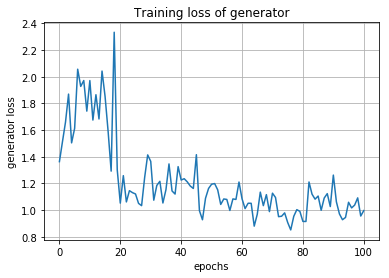

In [14]:
fig, ax = plt.subplots()
ax.plot(list(range(len(g_errors))), g_errors)
ax.set(
    xlabel='epochs', 
    ylabel='generator loss',
    title='Training loss of generator'
)
ax.grid()
plt.show()

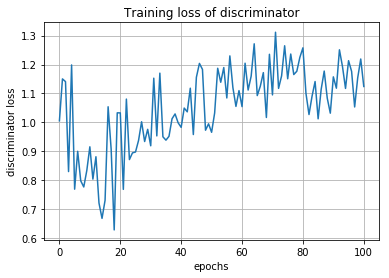

In [15]:
fig, ax = plt.subplots()
ax.plot(list(range(len(d_errors))), d_errors)
ax.set(
    xlabel='epochs', 
    ylabel='discriminator loss',
    title='Training loss of discriminator'
)
ax.grid()
plt.show()

### Images

Initially, the generator output is random.

Sample images from epoch #0


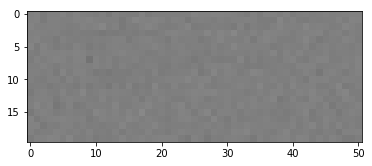

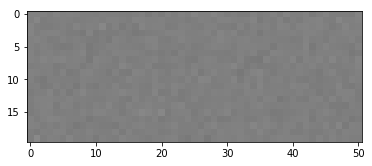

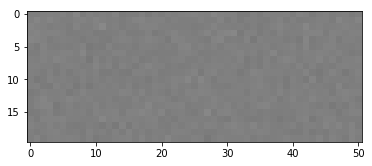

In [16]:
print("Sample images from epoch #{}".format(epoch_images[0][0]))
for image in epoch_images[0][1]:
    plt.figure()
    plt.imshow(image)

Note how quickly the network picks up on the padding.

Sample images from epoch #10


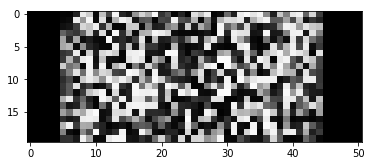

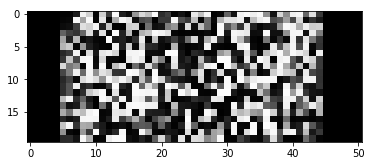

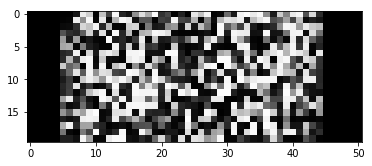

In [17]:
print("Sample images from epoch #{}".format(epoch_images[1][0]))
for image in epoch_images[1][1]:
    plt.figure()
    plt.imshow(image)

Sample images from epoch #20


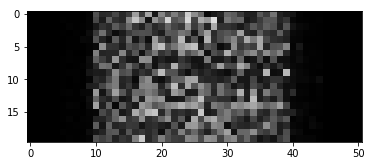

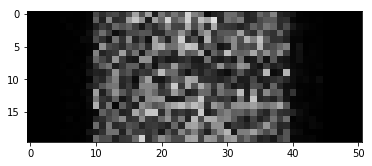

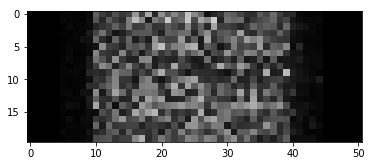

In [18]:
print("Sample images from epoch #{}".format(epoch_images[2][0]))
for image in epoch_images[2][1]:
    plt.figure()
    plt.imshow(image)

Sample images from epoch #30


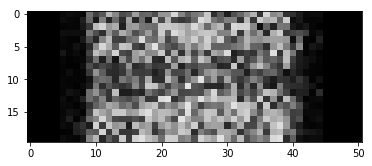

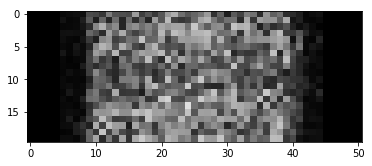

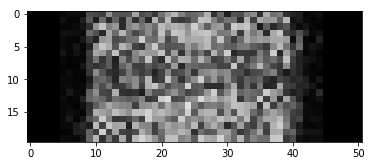

In [19]:
print("Sample images from epoch #{}".format(epoch_images[3][0]))
for image in epoch_images[3][1]:
    plt.figure()
    plt.imshow(image)

Sample images from epoch #40


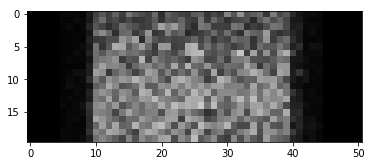

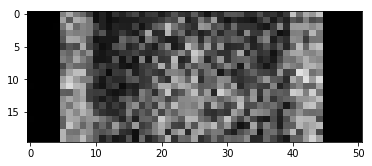

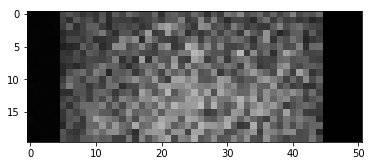

In [20]:
print("Sample images from epoch #{}".format(epoch_images[4][0]))
for image in epoch_images[4][1]:
    plt.figure()
    plt.imshow(image)

Sample images from epoch #50


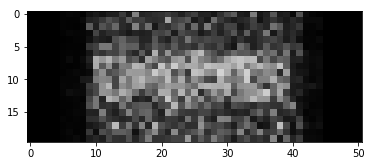

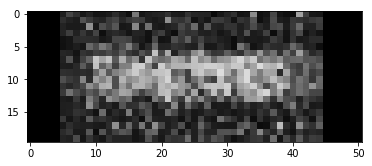

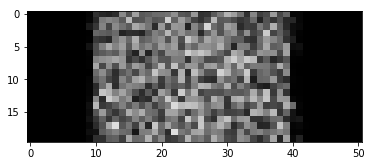

In [21]:
print("Sample images from epoch #{}".format(epoch_images[5][0]))
for image in epoch_images[5][1]:
    plt.figure()
    plt.imshow(image)

Sample images from epoch #60


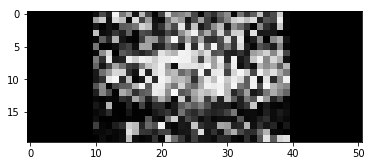

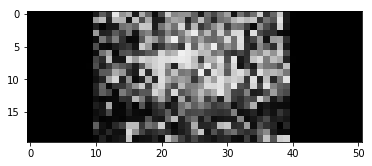

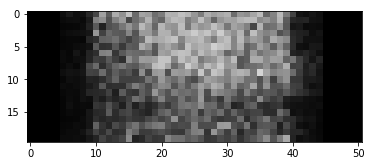

In [22]:
print("Sample images from epoch #{}".format(epoch_images[6][0]))
for image in epoch_images[6][1]:
    plt.figure()
    plt.imshow(image)

Sample images from epoch #70


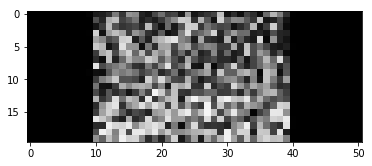

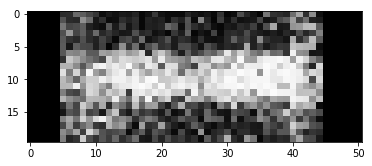

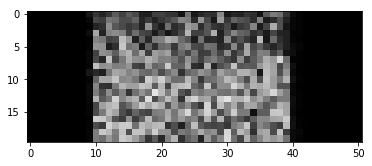

In [23]:
print("Sample images from epoch #{}".format(epoch_images[7][0]))
for image in epoch_images[7][1]:
    plt.figure()
    plt.imshow(image)

Sample images from epoch #80


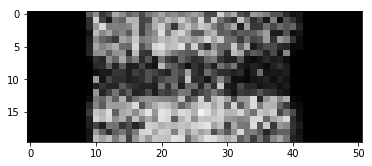

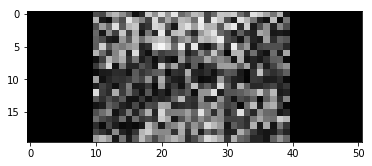

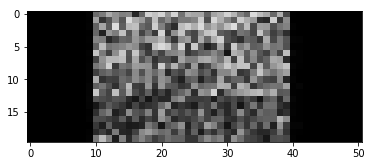

In [24]:
print("Sample images from epoch #{}".format(epoch_images[8][0]))
for image in epoch_images[8][1]:
    plt.figure()
    plt.imshow(image)

Sample images from epoch #90


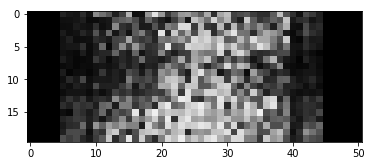

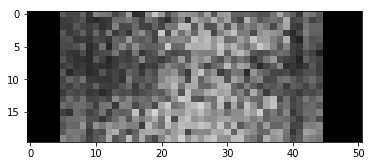

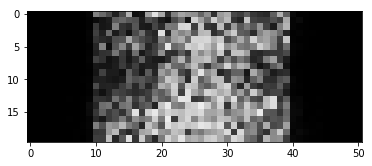

In [25]:
print("Sample images from epoch #{}".format(epoch_images[9][0]))
for image in epoch_images[9][1]:
    plt.figure()
    plt.imshow(image)

Sample images from epoch #100


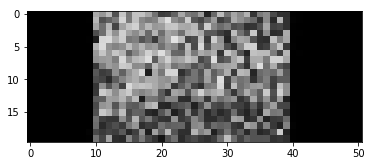

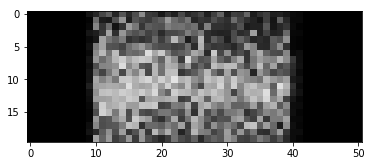

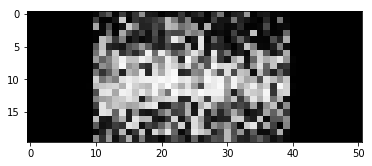

In [26]:
print("Sample images from epoch #{}".format(epoch_images[10][0]))
for image in epoch_images[10][1]:
    plt.figure()
    plt.imshow(image)

# Result

## Real Images

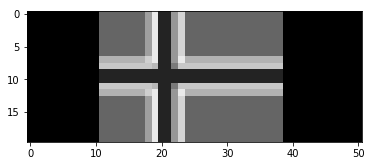

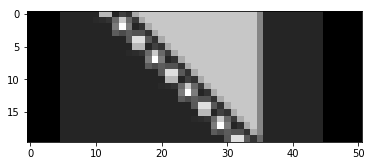

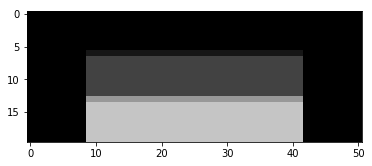

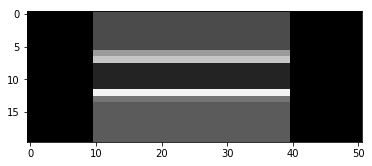

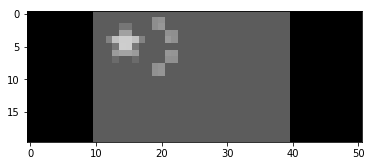

In [27]:
for image in random.sample(processed_images, 5):
    plt.figure()
    plt.imshow(decode_img(image))

## Fake Images

The generator learned to create a variety of flag styles, including vertical and horizontal stripes and little emblems. <br>Additionally, the generator mixes up the flag dimensions in line with the training data.

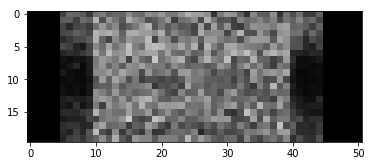

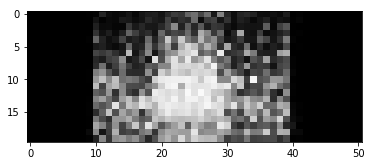

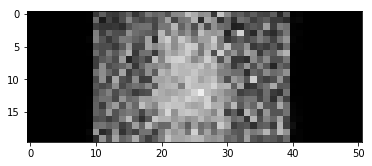

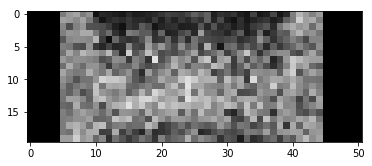

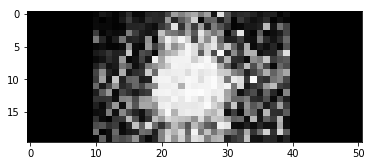

In [28]:
for image in [
    decode_img(g(torch.empty(100).normal_(0,1)).view(20,51).detach()),
    decode_img(g(torch.empty(100).normal_(0,1)).view(20,51).detach()),
    decode_img(g(torch.empty(100).normal_(0,1)).view(20,51).detach()),
    decode_img(g(torch.empty(100).normal_(0,1)).view(20,51).detach()),
    decode_img(g(torch.empty(100).normal_(0,1)).view(20,51).detach())
]:
    plt.figure()
    plt.imshow(image)

## Save Models

In [29]:
torch.save(g.state_dict(), "models/generator100")
torch.save(d.state_dict(), "models/discriminator100")